In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import joblib 

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import softmax

In [2]:
train = pd.read_csv("/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv")
test = pd.read_csv("/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/test_sent_emo.csv")
cv = pd.read_csv("/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/dev_sent_emo.csv")

# EDA

In [3]:
train.shape, cv.shape , test.shape

((9989, 11), (1109, 11), (2610, 11))

In [4]:
train.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


Emotion
neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: count, dtype: int64


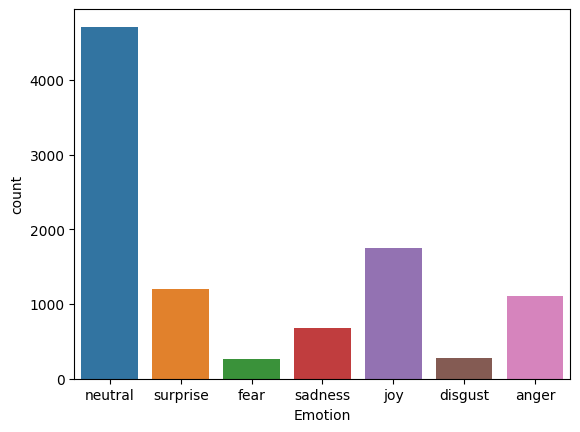

In [5]:
ax = sns.countplot(x=train['Emotion'], data=train)
print(train['Emotion'].value_counts())

Emotion
neutral     470
joy         163
anger       153
surprise    150
sadness     111
fear         40
disgust      22
Name: count, dtype: int64


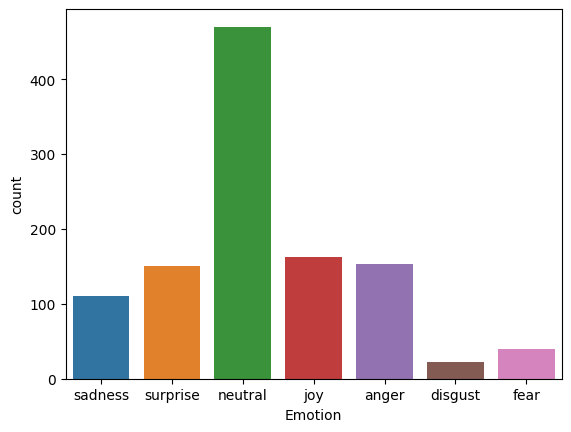

In [6]:
ax = sns.countplot(x=cv['Emotion'], data=cv)
print(cv['Emotion'].value_counts())

Emotion
neutral     1256
joy          402
anger        345
surprise     281
sadness      208
disgust       68
fear          50
Name: count, dtype: int64


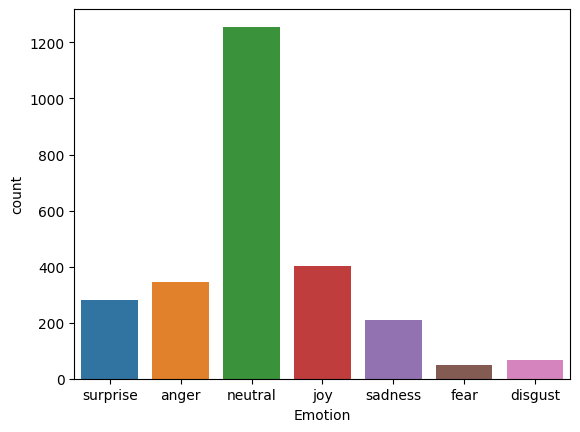

In [7]:
ax = sns.countplot(x=test['Emotion'], data=test)
print(test['Emotion'].value_counts())

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


In [9]:
cv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        1109 non-null   int64 
 1   Utterance     1109 non-null   object
 2   Speaker       1109 non-null   object
 3   Emotion       1109 non-null   object
 4   Sentiment     1109 non-null   object
 5   Dialogue_ID   1109 non-null   int64 
 6   Utterance_ID  1109 non-null   int64 
 7   Season        1109 non-null   int64 
 8   Episode       1109 non-null   int64 
 9   StartTime     1109 non-null   object
 10  EndTime       1109 non-null   object
dtypes: int64(5), object(6)
memory usage: 95.4+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


In [11]:
X_train , y_train = train[['Utterance']] , train[['Emotion']]
X_cv , y_cv = cv[['Utterance']] , cv[['Emotion']]
X_test , y_test = test[['Utterance']] , test[['Emotion']]

# Helper Functions

## Defining multiclass log loss

In [12]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

## Define a scorer to be used in Grid Search

In [13]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

## Using LabelEncoder to vectorise labels

In [14]:
lbl_enc = preprocessing.LabelEncoder()
y_train_enc = lbl_enc.fit_transform(y_train.Emotion.values)
y_cv_enc = lbl_enc.transform(y_cv.Emotion.values)
y_test_enc = lbl_enc.transform(y_test.Emotion.values)

In [15]:
y_train.Emotion.values[1:200]

array(['neutral', 'neutral', 'neutral', 'surprise', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'fear', 'neutral', 'surprise',
       'neutral', 'surprise', 'sadness', 'surprise', 'fear', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'joy', 'sadness',
       'surprise', 'neutral', 'disgust', 'sadness', 'neutral', 'neutral',
       'joy', 'neutral', 'joy', 'surprise', 'surprise', 'surprise',
       'neutral', 'neutral', 'neutral', 'surprise', 'sadness', 'neutral',
       'surprise', 'joy', 'surprise', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'joy', 'joy', 'joy', 'sadness', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'surprise',
       'joy', 'surprise', 'joy', 'neutral', 'neutral', 'anger', 'joy',
       'neutral', 'surprise', 'anger', 'anger', 'anger', 'neutral',
       'neutral', 'sadness', 'sadness', 'sadness', 'surprise', 'anger',
       'anger', 'anger', 'anger', 'neutral', 'anger', 'neutral',
     

In [16]:
y_train_enc[1:200]

array([4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 6, 4, 6, 5, 6, 2, 4, 4, 4, 4, 4,
       3, 5, 6, 4, 1, 5, 4, 4, 3, 4, 3, 6, 6, 6, 4, 4, 4, 6, 5, 4, 6, 3,
       6, 4, 4, 4, 4, 4, 3, 3, 3, 5, 4, 4, 4, 4, 4, 4, 6, 3, 6, 3, 4, 4,
       0, 3, 4, 6, 0, 0, 0, 4, 4, 5, 5, 5, 6, 0, 0, 0, 0, 4, 0, 4, 4, 4,
       4, 3, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 1, 0, 0, 0, 0, 0,
       0, 4, 4, 0, 4, 3, 4, 4, 3, 3, 3, 3, 4, 3, 1, 6, 1, 4, 2, 4, 6, 2,
       1, 0, 3, 4, 6, 4, 4, 4, 4, 6, 4, 4, 0, 4, 4, 5, 6, 5, 0, 5, 4, 5,
       4, 4, 4, 4, 4, 3, 0, 0, 0, 4, 0, 3, 3, 3, 3, 1, 6, 4, 4, 0, 3, 4,
       4, 2, 4, 2, 3, 3, 3, 3, 4, 4, 4, 3, 4, 3, 2, 4, 5, 6, 2, 4, 4, 4,
       3])

## Dataset preprocessing

In [17]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

def preprocess_text(data, text_column='Utterance'):
    """
    Cleans and preprocesses text data using stemming and stopword removal.

    Parameters:
    - data (pd.DataFrame): The dataframe containing the text data.
    - text_column (str): Name of the column containing text to clean.

    Returns:
    - pd.DataFrame: The dataframe with a new column `clean_utterance` and original text column dropped.
    """
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    corpus = []

    for i in range(len(data)):
        review = re.sub('[^a-zA-Z]', ' ', data[text_column][i])
        review = review.lower().split()
        review = [ps.stem(word) for word in review if word not in stop_words]
        corpus.append(' '.join(review))

    data = data.copy()
    data['clean_utterance'] = corpus
    data.drop(text_column, axis=1, inplace=True)
    return data


In [18]:
X_train = preprocess_text(X_train)
X_cv = preprocess_text(X_cv)
X_test = preprocess_text(X_test)

# Models

## Model 1: TFIDF + LR

In [19]:
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train['clean_utterance']) + list(X_cv['clean_utterance']) + list(X_test['clean_utterance']))
X_train_tfv =  tfv.transform(X_train['clean_utterance']) 
X_valid_tfv = tfv.transform(X_cv['clean_utterance'])
X_test_tfv = tfv.transform(X_test['clean_utterance'])

In [20]:
X_train_tfv.shape,X_valid_tfv.shape,X_test_tfv.shape

((9989, 3180), (1109, 3180), (2610, 3180))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


alpha = [10 ** x for x in range(-6, 3)]


# initialize Our first RandomForestRegressor model...
regr2 = LogisticRegression(max_iter=1000)

# declare parameters for hyperparameter tuning
parameters = {'C':alpha} 

# Perform cross validation 
clf = GridSearchCV(regr2,
                    param_grid = parameters,
                    scoring=mll_scorer,
                    n_jobs = -1,
                    verbose = 10, refit=True, cv=2)
result = clf.fit(X_train_tfv, y_train_enc)

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f 1(%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: -1.417577 using {'C': 1}
-1.536665 1(0.000177) with: {'C': 1e-06}
-1.536648 1(0.000177) with: {'C': 1e-05}
-1.536480 1(0.000177) with: {'C': 0.0001}
-1.534833 1(0.000178) with: {'C': 0.001}
-1.520889 1(0.000220) with: {'C': 0.01}
-1.463320 1(0.000341) with: {'C': 0.1}
-1.417577 1(0.004768) with: {'C': 1}
-1.622422 1(0.007542) with: {'C': 10}
-2.349451 1(0.009973) with: {'C': 100}


In [22]:
lr = LogisticRegression(C = 1, max_iter=1000)
lr.fit(X_train_tfv, y_train_enc)

LogisticRegression(C=1, max_iter=1000)

In [23]:
predictions = lr.predict_proba(X_train_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_train_enc, predictions))

logloss: 1.130 


In [24]:
predictions = lr.predict_proba(X_valid_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_cv_enc, predictions))

logloss: 1.477 


In [25]:
predictions = lr.predict_proba(X_test_tfv)
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, predictions))

logloss: 1.372 


## Inference

In [26]:
joblib.dump(lr, 'lr2.pkl') 
joblib.dump(tfv, 'tfidf.pkl') 

['tfidf.pkl']

In [27]:
import re

### Dataset Preprocessing 
from nltk.stem.porter import PorterStemmer
def preprocessor(sentence):
  ps = PorterStemmer()

  review = re.sub('[^a-zA-Z]', ' ', sentence)
  review = review.lower()
  review = review.split()

  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  return review

In [28]:
def mapper(ans):
  for i in ans:
    if i==0:
      return 'Anger'
    elif i==1:
      return 'Disgust'
    elif i==2:
      return 'Fear'
    elif i==3:
      return 'Joy'
    elif i==4:
      return 'Neutral'
    elif i==5:
      return 'Sadness'
    elif i==6:
      return 'Surprise'

In [29]:
def predictor(sentence):
  lst = []
  my_model = joblib.load('lr2.pkl') 
  tfv = joblib.load('tfidf.pkl')  

  sent = preprocessor(sentence)

  lst.append(sent)
  sent_tfv = tfv.transform(lst)
  ans = my_model.predict(sent_tfv) 
  mapped_ans = mapper(ans)
  return mapped_ans

## Sample Predictions

In [30]:
ans = predictor('I hate you from bottom of my heart')
print(ans)

Anger


In [31]:
ans = predictor('Oh Wow what a beautiful place')
print(ans)

Joy


In [32]:
ans = predictor('I am really sorry, I am feeling really very guilty')
print(ans)

Sadness
